# Pennsbury High School Tweet Analysis

## Accessing Twitter

In [1]:
import twitter
import json

def oauth_login():
    # XXX: Go to  to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
    # for more information on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'ldJnCzzuCM3Col1pMcmSyVaDT'
    CONSUMER_SECRET = 'RWCNFVehlhAHzarhuAJA7vjSfoQx1FB96HLY7VR2U1d6mDj31w'
    OAUTH_TOKEN = '1112769260818972672-FFlTewXnvPcbcJAM04vYqk8DPxjYcG'
    OAUTH_TOKEN_SECRET = 'D5EuZziAVsW26tHuZCGYRw2uiKPdfdUgaaIszGatEsdB6'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

print(twitter_api)

## Searching for tweets

In [2]:
def twitter_search(twitter_api, q, max_results=200, **kw):
    
    search_results = twitter_api.search.tweets(q=q, count=100, **kw)
    
    statuses = search_results['statuses']
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://developer.twitter.com/en/docs/basics/rate-limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    # Read this https://developer.twitter.com/en/docs/tweets/timelines/guides/working-with-timelines to understand why we use 
    # max_id to populate tweets
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError as e: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

# Sample usage

twitter_api = oauth_login()

q = "Pennsbury"
results = twitter_search(twitter_api, q, max_results=1000)

In [3]:
for i in range(5):
    print()
    print(results[i]['text'])
    print('Favorites: ',results[i]['favorite_count'])
    print('Retweets: ', results[i]['retweet_count'])


“did you go to college, no wait, did you even finish highschool with a brain like that?” “what’d you go to pennsbur… https://t.co/rvxyJIsDzW
Favorites:  0
Retweets:  0

RT @victoriavouk: Hi Pennsbury grads. Watch big mouth?? Richard kind is the voice of Marty and Zach Woods is the voice of Daniel. Of all of…
Favorites:  0
Retweets:  1

RT @costareports: RIP to the men and women who gave their lives for this nation, including Nate DeTample, Pennsbury High '04, who died Augu…
Favorites:  0
Retweets:  295

Open House Today, 1-3pm, 39 Nutmeg Rd, Levittown, North Park, Pennsbury Schools, New Listing-… https://t.co/nCT7INHlhd
Favorites:  0
Retweets:  0

Open House Today, 1-3pm, 39 Nutmeg Rd, Levittown, North Park, Pennsbury Schools, New Listing-… https://t.co/APCLH7Rxku
Favorites:  0
Retweets:  0


## Extracting text, screen names, and hashtags from tweets

In [4]:
status_texts = [ status['text']
                 for status in results ]

screen_names = [ user_mention['screen_name']
                 for status in results
                     for user_mention in status['entities']['user_mentions'] ]

hashtags = [ hashtag['text']
             for status in results
                 for hashtag in status['entities']['hashtags'] ]

# Compute a collection of all words from all tweets
words = [ w
          for t in status_texts
              for w in t.split() ]

## Cleaning text

In [5]:
stopwords = ["0", "in", "of", "the", "a", "I", "pennsbury", "Pennsbury", "High", "high", "School", "school", "RT", "@", "to"]

for word in words:
    if word.lower() in stopwords:
        words.remove(word)

## Simple frequency analysis

In [7]:
from collections import Counter
from prettytable import PrettyTable

for item in [words, screen_names, hashtags]:
    c = Counter(item)
    c.most_common()[:10]
    
for label, data in (('Word', words),
                    ('Screen Name', screen_names),
                    ('Hashtag', hashtags)):
    pt = PrettyTable(field_names=[label, 'Count'])
    c = Counter(data)
    [ pt.add_row(kv) for kv in c.most_common()[:10] ]
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
    print(pt)

+------------+-------+
| Word       | Count |
+------------+-------+
| RT         |   142 |
| 2019       |   116 |
| on         |    70 |
| Lady       |    69 |
| Area       |    67 |
| Hazleton   |    65 |
| 1          |    56 |
| (Batting:  |    53 |
| (Pitching: |    53 |
| at         |    52 |
+------------+-------+
+-----------------+-------+
| Screen Name     | Count |
+-----------------+-------+
| DJPaulyD        |    60 |
| PIAASports      |    20 |
| CentralYorkAth  |    10 |
| pennsburyfb     |     8 |
| SOLsports       |     8 |
| Cawley_TV       |     8 |
| AustinHertzog   |     8 |
| CougarHazleton  |     6 |
| PburyHSBaseball |     5 |
| sstallone5      |     5 |
+-----------------+-------+
+-------------------+-------+
| Hashtag           | Count |
+-------------------+-------+
| BestPromInAmerica |    28 |
| bestprominamerica |    27 |
| PIAAVolleyball    |    15 |
| prom2019          |    13 |
| tlsports          |     8 |
| wvcsoftball       |     8 |
| Pennsbury     

In [8]:
retweets = [
            # Store out a tuple of these three values ...
            (status['retweet_count'], 
             status['retweeted_status']['user']['screen_name'],
             status['retweeted_status']['id'],
             status['text']) 
            
            # ... for each status ...
            for status in results 
            
            # ... so long as the status meets this condition.
                if 'retweeted_status' in status.keys()
           ]

# Slice off the first 5 from the sorted results and display each item in the tuple

pt = PrettyTable(field_names=['Count', 'Screen Name', 'Tweet ID', 'Text'])
[ pt.add_row(row) for row in sorted(set(retweets), reverse=True)[:5] ]
pt.max_width['Text'] = 50
pt.align= 'l'
print(pt)

+-------+--------------+---------------------+----------------------------------------------------+
| Count | Screen Name  | Tweet ID            | Text                                               |
+-------+--------------+---------------------+----------------------------------------------------+
| 295   | costareports | 1132695885828317187 | RT @costareports: RIP to the men and women who     |
|       |              |                     | gave their lives for this nation, including Nate   |
|       |              |                     | DeTample, Pennsbury High '04, who died Augu…       |
| 67    | DJPaulyD     | 1134165035226243072 | RT @DJPaulyD: THIS SATURDAY PROM BOUT TO BE LIT    |
|       |              |                     | Pennsbury 🔥🔥🔥🔥 #bestprominamerica 🙌🏽🙌🏽             |
| 32    | DJPaulyD     | 1135152234214428674 | RT @DJPaulyD: I Love Prom This Time A Yearrrrr!!!! |
|       |              |                     | 🙌🏽🙌🏽 #BestPromInAmerica #prom2019🎓 U Guys Rock!! @ |


## Visualizing word frequencies

In [10]:
import wordcloud

words

wc = wordcloud.WordCloud(stopwords=['https','RT','CO'])
clean_string = ','.join(words)
wc.generate(clean_string)

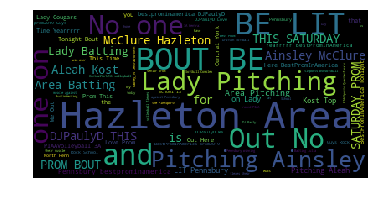

In [11]:
from matplotlib import pyplot as plt
plt.imshow(wc.recolor( random_state=3))
plt.axis('off')
plt.show()

## Sentiment analysis

In [12]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\parth\AppData\Roaming\nltk_data...


True

In [14]:
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

scores = np.zeros(len(results))

for i, t in enumerate(results):
    # Extract the text portion of the tweet
    text = t['text']

    # Measure the polarity of the tweet
    polarity = analyzer.polarity_scores(text)

    # Store the normalized, weighted composite score
    scores[i] = polarity['compound']

most_positive = np.argmax(scores)
most_negative = np.argmin(scores)

print('{0:6.3f} : "{1}"'.format(scores[most_positive], results[most_positive]['text']))

print('{0:6.3f} : "{1}"'.format(scores[most_negative], results[most_negative]['text']))

 0.923 : "@DJ_Paulie_D thank you for doing my kids prom at pennsbury your a great guy thank u again love u"
-0.636 : "Kat said she’s still so sad that Taylor swift cancelled on coming to pennsbury prom. “I would have done anything for that”, she says."


In [15]:
analyzer = SentimentIntensityAnalyzer()

positive_tweets = []
negative_tweets = []
scores = np.zeros(len(results))
for i, tweet in enumerate(results):
    polarity = analyzer.polarity_scores(tweet['text'])
    if polarity['neg'] > 0.0:
        negative_tweets.append(tweet)
        
    if polarity['pos'] > 0.0:
        positive_tweets.append(tweet)
        
    scores[i] = polarity['compound']
        
print("Negative Tweet Count:" + str(len(negative_tweets)))
print("Positive Tweet Count:" + str(len(positive_tweets)))
print()

most_positive = np.argmax(scores)
most_negative = np.argmin(scores)

Negative Tweet Count:50
Positive Tweet Count:153



## Analyzing common occurrences

In [16]:
from collections import Counter

for item in [words, screen_names, hashtags]:
    c = Counter(item)
    print(c.most_common()[:10]) # top 10
    print()

[('RT', 142), ('2019', 116), ('on', 70), ('Lady', 69), ('Area', 67), ('Hazleton', 65), ('1', 56), ('(Batting:', 53), ('(Pitching:', 53), ('at', 52)]

[('DJPaulyD', 60), ('PIAASports', 20), ('CentralYorkAth', 10), ('pennsburyfb', 8), ('SOLsports', 8), ('Cawley_TV', 8), ('AustinHertzog', 8), ('CougarHazleton', 6), ('PburyHSBaseball', 5), ('sstallone5', 5)]

[('BestPromInAmerica', 28), ('bestprominamerica', 27), ('PIAAVolleyball', 15), ('prom2019', 13), ('tlsports', 8), ('wvcsoftball', 8), ('Pennsbury', 7), ('pennsburyprom', 5), ('piaaplayoffs', 3), ('PennsburyProm', 2)]



Text(0.5, 0, 'Word Rank')

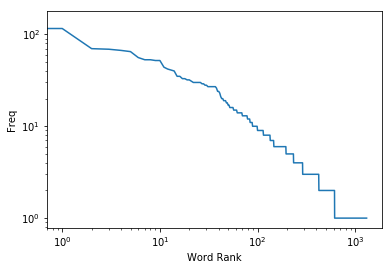

In [17]:
#Visualization
import matplotlib.pyplot as plt
%matplotlib inline

word_counts = sorted(Counter(words).values(), reverse=True)

plt.loglog(word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

## Generating word clouds

In [18]:
import wordcloud

In [19]:
wc = wordcloud.WordCloud(stopwords=['https','RT','CO'])
clean_string = ','.join(words)
wc.generate(clean_string)

In [20]:
positive_texts = [ tweet['text']
                 for tweet in positive_tweets ]

negative_texts = [ tweet['text']
                 for tweet in negative_tweets ]

positive_words = [ w
          for t in positive_texts
              for w in t.split() ]

negative_words = [ w
          for t in negative_texts
              for w in t.split() ]

### Positive sentiment word cloud

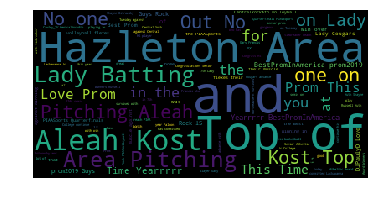

In [21]:
wc = wordcloud.WordCloud(stopwords=['https','RT','CO', 'Pennsbury', 'High', 'School', 'to'])
clean_string = ','.join(positive_words)
wc.generate(clean_string)

plt.imshow(wc.recolor( random_state=3))
plt.axis('off')
plt.show()

### Negative sentiment word cloud

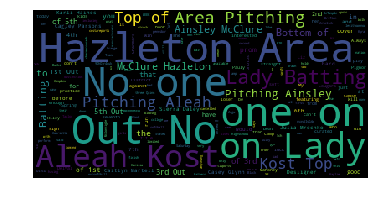

In [22]:
wc = wordcloud.WordCloud(stopwords=['https','RT','CO', 'Pennsbury', 'High', 'School'])
clean_string = ','.join(negative_words)
wc.generate(clean_string)

plt.imshow(wc.recolor( random_state=3))
plt.axis('off')
plt.show()